# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import string

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

import pickle
from tqdm import tqdm
import os
from collections import Counter

# ============================== loading libraries ===========================================

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

from sklearn.feature_extraction.text import CountVectorizer

from prettytable import PrettyTable

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import itertools
from sklearn.tree import DecisionTreeClassifier


C:\Users\Nit-prj1010\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


##  Data Import and Preprocessing

**Load preprocessed 'final' data**

In [2]:
final = pickle.load(open('preprocessed_final', 'rb'))

 *Checkpoint 2: Data is now sorted based on Time and preprocessed.*

In [3]:
# Create X and Y variable 
X = final['CleanedText'].values
y= final['Score'].values

In [4]:
type(X)

numpy.ndarray

In [5]:
type(y)

numpy.ndarray

In [6]:
# ss
from sklearn.model_selection import train_test_split

# Splitting into train and test in the ratio 70:30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,shuffle=False, random_state=507)
#X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.30, shuffle=False, random_state=507)

In [7]:
print("Train Set:",X_train.shape, y_train.shape[0])
print("Test Set:",X_test.shape, y_test.shape[0])

Train Set: (61441,) 61441
Test Set: (26332,) 26332


*Checkpoint 3: Data has been partioned into train, cv and test*

**Defining functions that we will be using throughout the notebook for BoW, TFIDF, AvgW2V, TFIDF-WW2V**


**hyperparameter tuning**

In [15]:
def get_best_hyperparameters(vectorizer, X_train, X_test, y_train, y_test):
  
    """
    This funtion takes in the vectorizer,  and performs DecisionTreeClassifier hyperparameter tuning using GridSearchCV with 5 fold cv 
    Returns the value of hyperparameter alpha and draws the error plot for various values of alpha
  
    Usage: get_best_hyperparameter_C(vectorizer, X_train, X_test, y_train, y_test, penalty)
    """
      
    params_dict = {
                "max_depth": [1, 5, 10, 50, 100, 500, 1000], 
                "min_samples_split": [5, 10, 100, 500]
                #"max_depth": [1, 5, 10], 
                #"min_samples_split": [5, 10]
               }
    
    clf = DecisionTreeClassifier(random_state= 507)
   
    # Using GridSearchCVSearchCV with 5 fold cv
    gs_obj = GridSearchCV(clf, param_grid = params_dict, scoring = 'roc_auc', cv=3)

    gs_obj.fit(X_train, y_train)
  
  
    # Code https://stackoverflow.com/questions/42793254/what-replaces-gridsearchcv-grid-scores-in-scikit#answer-42800056
    means = gs_obj.cv_results_['mean_test_score']
    stds = gs_obj.cv_results_['std_test_score']


    t1 = PrettyTable()
    t1.field_names = ['Mean CV Score', 'Std CV Score', 'Param']

    for mean, std, params in zip(means, stds, gs_obj.cv_results_['params']):
        t1.add_row([round(mean, 3), round(std * 2,5), params])

    print(t1) 
  
    print("\nThe best estimator:{}".format(gs_obj.best_estimator_))
    print("\nThe best score is:{}".format(gs_obj.best_score_))
    print("The best value of hyperparameters are:{}".format(gs_obj.best_params_))

    # Returns the mean accuracy on the given test data and labels.
    print("Mean Score: {}".format(gs_obj.score(X_test, y_test)))
    #print("penalty: {}".format(gs_obj.best_params_['penalty']))
    
    #plotting heatmap
    # https://stackoverflow.com/questions/48791709/how-to-plot-a-heat-map-on-pivot-table-after-grid-search
    
    plt.figure(1)
    plt.figure(figsize=(15, 4))
    
    plt.subplot(121)
    pvt = pd.pivot_table(pd.DataFrame(gs_obj.cv_results_),
          values='mean_test_score', index='param_max_depth', columns='param_min_samples_split')
    
    ax = sns.heatmap(pvt,annot = True)
    ax.set_title("CV set results")
    
    plt.subplot(122) 
    pvt2 = pd.pivot_table(pd.DataFrame(gs_obj.cv_results_),
          values='mean_train_score', index='param_max_depth', columns='param_min_samples_split')
    
    ax2 = sns.heatmap(pvt2,annot = True, )
    ax2.set_title('training set results')
    

In [ ]:
plt.figure(1)
plt.figure(figsize=(15, 4))


plt.subplot(121)  # Test confusion matrix
cnf_matrix = confusion_matrix(y_test, model_bow.predict(X_test_bow))
np.set_printoptions(precision=2)
class_names = ['Negative', 'Positive']
# Plot non-normalized confusion matrix
#plt.figure()
plot_confusion_matrix_heatmap(cnf_matrix, classes=class_names, title='Test Set Confusion Matrix');

plt.subplot(122) # Train Confusion matrix
cnf_matrix = confusion_matrix(y_train, model_bow.predict(X_train_bow))
np.set_printoptions(precision=2)
class_names = ['Negative', 'Positive']
# Plot non-normalized confusion matrix
#plt.figure()
plot_confusion_matrix_heatmap(cnf_matrix, classes=class_names, title='Train Set Confusion Matrix');

**train and test AUC**

In [9]:
def plot_auc(model, X_train, X_test):
    
    """
    This function will plot the AUC for the vectorized train and test data.
    Returns the plot and also the values of auc for train and test
    
    Usage: auc_train, auc_test = plot_auc(model, X_train, X_test)
    """
    train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(X_train)[:,1])
    test_fpr, test_tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])

    plt.plot([0,1],[0,1],'k--')
    plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
    plt.legend()
    plt.xlabel("fpr")
    plt.ylabel("tpr")
    plt.title("ROC Curve")
    plt.show()
    
    print("train AUC: {}".format(auc(train_fpr, train_tpr)))
    print("test AUC: {}".format(auc(test_fpr, test_tpr)))
    
    
    return auc(train_fpr, train_tpr), auc(test_fpr, test_tpr)
    

**important features**

In [11]:
# https://stackoverflow.com/questions/26976362/how-to-get-most-informative-features-for-scikit-learn-classifier-for-different-c
def most_informative_feature_for_binary_classification(vectorizer, classifier, n=20):
  
    """
     Takes in the vectorizer, classifier (model) and the number of important features to return
  
     Usage: most_informative_feature_for_binary_classification(vectorizer, classifier, n=20)
    """
    class_labels = classifier.classes_
    feature_names = vectorizer.get_feature_names()
    
    topn_class_1 = sorted(zip(classifier.feature_importances_, feature_names))[-n:]
    
        
    t2 = PrettyTable()
    t2.field_names = ['Coefficient (Importance)', 'Feature Name']
 
    for coef, feat in reversed(topn_class_1):
        t2.add_row([abs(coef), feat])
      
      
    print(t2)  
    del (t2)

**print confustion matrix**

In [12]:
def print_confusion_matrix(model, X_train, X_test):
    """
    Takes in the model, X_train, X_test and prints the confusion matrix
    Usage: print_confusion_matrix(model, X_train, X_test)
    """
    print("*****Train confusion matrix*****")
    print(confusion_matrix(y_train, model.predict(X_train)))
    print("\n*****Test confusion matrix*****")
    print(confusion_matrix(y_test, model.predict(X_test)))

**heat map of confusion matrix**

In [13]:
# Code modified from sklearn tutorial: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

# Heat map of confusion matrix

def plot_confusion_matrix_heatmap(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    #if normalize:
     #   cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
     #   print("Normalized confusion matrix")
    #else:
      #  print('Confusion matrix')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

**visualize decision tree**

In [18]:
import graphviz
from sklearn import tree

In [30]:
# code inspired from: https://scikit-learn.org/stable/modules/tree.html
def plot_decision_tree(vectorizer, model):
    # for visualization of tree
    dot_data = tree.export_graphviz(model_bow_viz, out_file=None, 
                     feature_names=bow_vectorizer.get_feature_names(),  
                     class_names=['positive','negative'],
                   filled=True, rounded=True,  
                      special_characters=True)  
    graph = graphviz.Source(dot_data)  
    return graph

# [4.1] BAG OF WORDS

In [10]:
# ss
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer= CountVectorizer(ngram_range=(1,2), min_df=10, max_features=10000)
bow_vectorizer.fit(X_train) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = bow_vectorizer.transform(X_train)
#X_cv_bow = vectorizer.transform(X_cv)
X_test_bow = bow_vectorizer.transform(X_test)

print("After vectorizations")
print(X_train_bow.shape, y_train.shape)
#print(X_cv_bow.shape, y_cv.shape)
print(X_test_bow.shape, y_test.shape)
print("="*100)

After vectorizations
(61441, 10000) (61441,)
(26332, 10000) (26332,)


In [11]:
print("the type of count vectorizer ",type(X_train_bow))
print("the shape of cut text BOW vectorizer ",X_train_bow.get_shape())
print("the number of unique words: ", X_train_bow.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of cut text BOW vectorizer  (61441, 10000)
the number of unique words:  10000


**Standardize the data:** Not standardizing data as we are not dealing with distances unlike previous alogrithms.

In [ ]:
# We will set the attribute with_mean = False, as StandardScaler does not work on sparse matrix
# when attempted on sparse matrices, because centering them entails building a dense matrix which in common use cases
# is likely to be too large to fit in memory.  ---> sklearn documentation

# from sklearn.preprocessing import StandardScaler
# X_train_bow=StandardScaler(with_mean=False).fit_transform(X_train_bow)
# X_test_bow=StandardScaler(with_mean=False).fit_transform(X_test_bow)

# print(X_train_bow.shape, y_train.shape) 

# print(X_test_bow.shape, y_test.shape) 

## [5.1] Applying Decision Trees on BOW,<font color='red'> SET 1</font>

+---------------+--------------+-----------------------------------------------+
| Mean CV Score | Std CV Score |                     Param                     |
+---------------+--------------+-----------------------------------------------+
|     0.614     |   0.02453    |    {'max_depth': 1, 'min_samples_split': 5}   |
|     0.614     |   0.02453    |   {'max_depth': 1, 'min_samples_split': 10}   |
|     0.614     |   0.02453    |   {'max_depth': 1, 'min_samples_split': 100}  |
|     0.614     |   0.02453    |   {'max_depth': 1, 'min_samples_split': 500}  |
|     0.698     |    0.0168    |    {'max_depth': 5, 'min_samples_split': 5}   |
|     0.698     |    0.0168    |   {'max_depth': 5, 'min_samples_split': 10}   |
|     0.698     |   0.01639    |   {'max_depth': 5, 'min_samples_split': 100}  |
|     0.699     |   0.01619    |   {'max_depth': 5, 'min_samples_split': 500}  |
|     0.725     |   0.04433    |   {'max_depth': 10, 'min_samples_split': 5}   |
|     0.728     |    0.0443 

<Figure size 432x288 with 0 Axes>

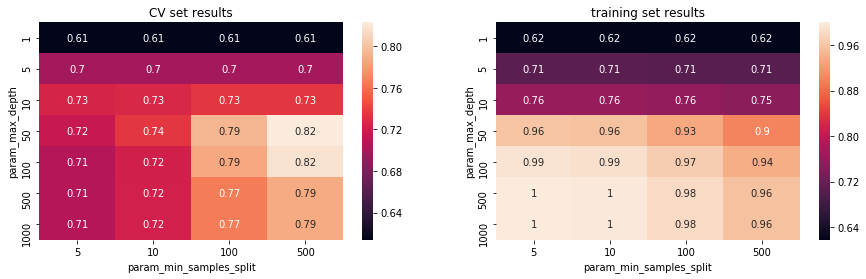

In [16]:
# get hyperparameter using gridsearchcv
get_best_hyperparameters(bow_vectorizer, X_train_bow, X_test_bow, y_train, y_test)

In [20]:
#fit the model on test set
model_bow = DecisionTreeClassifier(max_depth= 50, min_samples_split= 500, random_state= 507)
model_bow.fit(X_train_bow,y_train)
y_pred = model_bow.predict(X_test_bow)

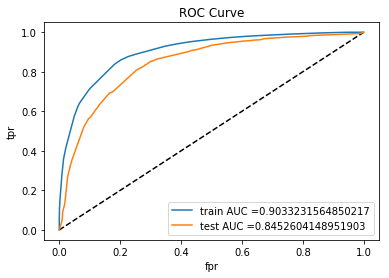

train AUC: 0.9033231564850217
test AUC: 0.8452604148951903


In [21]:
# plot roc
auc_train_bow, auc_test_bow = plot_auc(model_bow, X_train_bow, X_test_bow)

In [22]:
# confusion matrix
print_confusion_matrix(model_bow, X_train_bow, X_test_bow)

*****Train confusion matrix*****
[[ 5243  4381]
 [ 2253 49564]]

*****Test confusion matrix*****
[[ 2163  2394]
 [ 1317 20458]]


<Figure size 432x288 with 0 Axes>

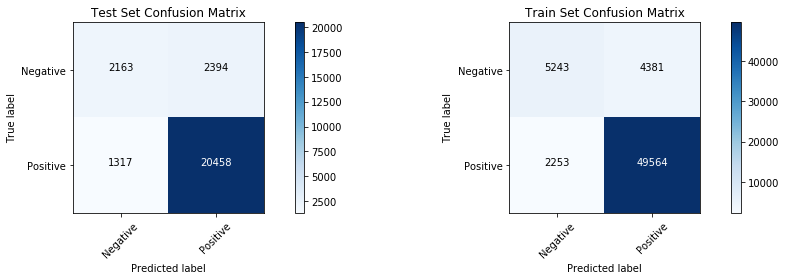

In [82]:
# heatmap of confusion matrix
plt.figure(1)
plt.figure(figsize=(15, 4))


plt.subplot(121)  # Test confusion matrix
cnf_matrix = confusion_matrix(y_test, model_bow.predict(X_test_bow))
np.set_printoptions(precision=2)
class_names = ['Negative', 'Positive']
# Plot non-normalized confusion matrix
#plt.figure()
plot_confusion_matrix_heatmap(cnf_matrix, classes=class_names, title='Test Set Confusion Matrix');

plt.subplot(122) # Train Confusion matrix
cnf_matrix = confusion_matrix(y_train, model_bow.predict(X_train_bow))
np.set_printoptions(precision=2)
class_names = ['Negative', 'Positive']
# Plot non-normalized confusion matrix
#plt.figure()
plot_confusion_matrix_heatmap(cnf_matrix, classes=class_names, title='Train Set Confusion Matrix');


**Observation**
1. For the BoW vectorizer, we calculated max_depth= 50 and min_samples_split= 500 using GridSearchCV for the DecisionTreeClassifier. 
2. We got train AUC: 0.9033231564850217 and test AUC: 0.8452604148951903 
3. Using the confusion matrix, we can say that our model correctly predicted 20458 positive reviews and 2163 negative reviews.
4. The model incorrectly classified 1317 negative reviews and 2394 positive reviews.

### [5.1.1] Top 20 important features from<font color='red'> SET 1</font>

In [24]:
# get top 20 important features
most_informative_feature_for_binary_classification(bow_vectorizer, model_bow)

+--------------------------+------------------+
| Coefficient (Importance) |   Feature Name   |
+--------------------------+------------------+
|   0.08074660036001163    |       not        |
|   0.054264591076350455   |      great       |
|   0.04414659552886127    |      worst       |
|   0.033922039825206335   |   disappointed   |
|    0.0337595221175283    |     not buy      |
|   0.03004935828669208    |      waste       |
|   0.025471753452879588   |     horrible     |
|   0.02504340706488353    |    not worth     |
|   0.02472941486610792    | not disappointed |
|   0.024168343015224455   |      return      |
|   0.02297280640602137    |     terrible     |
|   0.022686454236523733   |      awful       |
|   0.018810697405536203   |       best       |
|   0.017497441091217626   |       bad        |
|   0.01695800997713052    |    delicious     |
|    0.0167923626480178    |       love       |
|   0.014768774728228932   |     not good     |
|   0.014033097386979507   |  not recomm

### [5.1.2] Graphviz visualization of Decision Tree on BOW,<font color='red'> SET 1</font>

In [25]:
model_bow_viz = DecisionTreeClassifier(max_depth= 3, min_samples_split= 500, random_state= 507)
model_bow_viz.fit(X_train_bow,y_train)
y_pred = model_bow_viz.predict(X_test_bow)

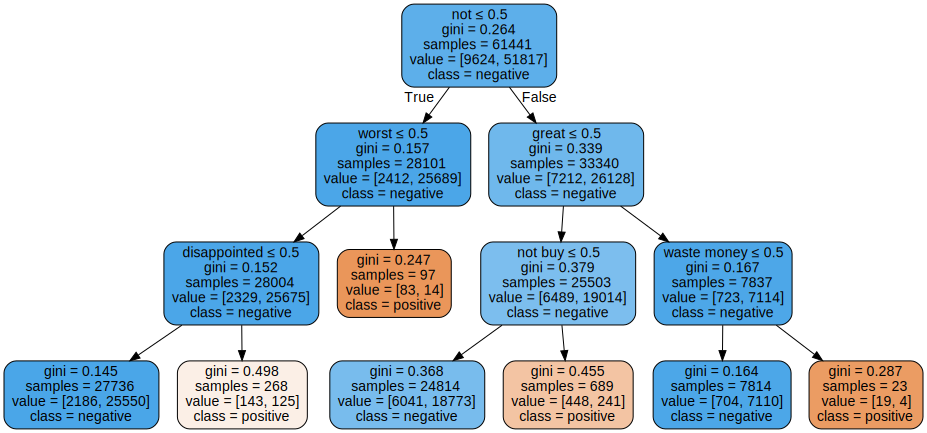

In [31]:
dt = plot_decision_tree(bow_vectorizer, model_bow_viz)
dt

**Feature Engineering** Let us perform FE to see if we can further improve the model. Here, we will append length of reviews as another feature.

In [17]:
def get_text_length(x):
    """
     This function takes in a array and returns the length of the elements in the array.
    """
    return np.array([len(t) for t in x]).reshape(-1, 1)

In [18]:
rev_len_X_train = get_text_length(X_train)
rev_len_X_test = get_text_length(X_test)

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer_fe = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=10000)
bow_vectorizer_fe.fit(X_train) # fit has to happen only on train data

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=10000, min_df=10,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [20]:
# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = bow_vectorizer_fe.transform(X_train)
X_test_bow = bow_vectorizer_fe.transform(X_test)

print("After vectorizations")
print(X_train_bow.shape, y_train.shape)
print(X_test_bow.shape, y_test.shape)
print("="*100)

After vectorizations
(61441, 10000) (61441,)
(26332, 10000) (26332,)


**Standardize the data:** Not standardizing data as we are not dealing with distances.

In [ ]:
# We will set the attribute with_mean = False, as StandardScaler does not work on sparse matrix
# when attempted on sparse matrices, because centering them entails building a dense matrix which in common use cases
# is likely to be too large to fit in memory.  ---> sklearn documentation

# from sklearn.preprocessing import StandardScaler
# X_train_bow=StandardScaler(with_mean=False).fit_transform(X_train_bow)
# X_test_bow=StandardScaler(with_mean=False).fit_transform(X_test_bow)

# print(X_train_bow.shape, y_train.shape) 

# print(X_test_bow.shape, y_test.shape) 

In [21]:
type(rev_len_X_train)


numpy.ndarray

In [22]:
type(X_train_bow)

scipy.sparse.csr.csr_matrix

In [23]:
from scipy.sparse import hstack
# Here we append the sparse matrix and the dense array that contains the length of the text passed to it
X_train_bow_fe = hstack((X_train_bow, np.array(rev_len_X_train)))
X_test_bow_fe = hstack((X_test_bow, np.array(rev_len_X_test)))

+---------------+--------------+-----------------------------------------------+
| Mean CV Score | Std CV Score |                     Param                     |
+---------------+--------------+-----------------------------------------------+
|     0.614     |   0.02453    |    {'max_depth': 1, 'min_samples_split': 5}   |
|     0.614     |   0.02453    |   {'max_depth': 1, 'min_samples_split': 10}   |
|     0.614     |   0.02453    |   {'max_depth': 1, 'min_samples_split': 100}  |
|     0.614     |   0.02453    |   {'max_depth': 1, 'min_samples_split': 500}  |
|     0.698     |   0.01642    |    {'max_depth': 5, 'min_samples_split': 5}   |
|     0.698     |   0.01643    |   {'max_depth': 5, 'min_samples_split': 10}   |
|     0.698     |   0.01638    |   {'max_depth': 5, 'min_samples_split': 100}  |
|     0.699     |   0.01619    |   {'max_depth': 5, 'min_samples_split': 500}  |
|     0.725     |   0.04647    |   {'max_depth': 10, 'min_samples_split': 5}   |
|     0.727     |   0.04583 

<Figure size 432x288 with 0 Axes>

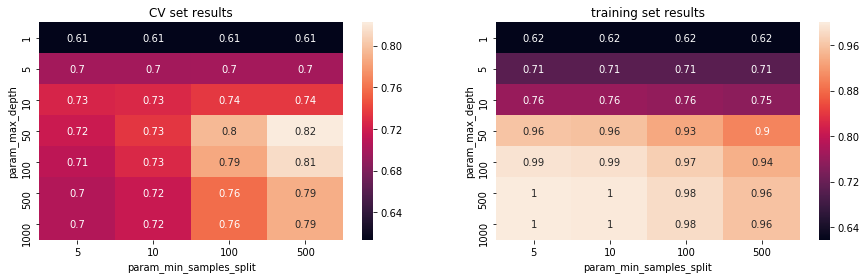

In [24]:
# Get the best hyperparameter using GridSearchCV with penalty l1 and cv = 5
get_best_hyperparameters(bow_vectorizer_fe, X_train_bow_fe, X_test_bow_fe, y_train, y_test)

In [90]:
model_bow_fe = DecisionTreeClassifier(max_depth= 50,min_samples_split= 500, random_state= 507)
model_bow_fe.fit(X_train_bow_fe,y_train)
y_pred = model_bow_fe.predict(X_test_bow_fe)

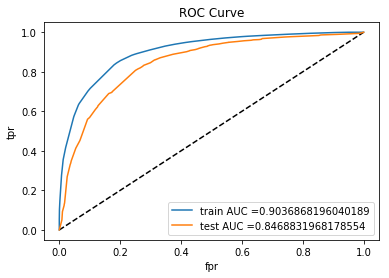

train AUC: 0.9036868196040189
test AUC: 0.8468831968178554


In [91]:
# AUC-ROC plot
auc_train_bow_fe, auc_test_bow_fe = plot_auc(model_bow_fe, X_train_bow_fe, X_test_bow_fe)

In [92]:
# Confusion Matrix
print_confusion_matrix(model_bow_fe, X_train_bow_fe, X_test_bow_fe)

*****Train confusion matrix*****
[[ 5235  4389]
 [ 2254 49563]]

*****Test confusion matrix*****
[[ 2165  2392]
 [ 1286 20489]]


<Figure size 432x288 with 0 Axes>

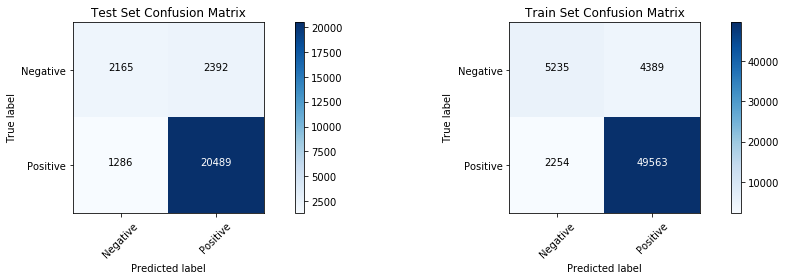

In [93]:
# Confustion Matrix heatmap
plt.figure(1)
plt.figure(figsize=(15, 4))


plt.subplot(121)  # Test confusion matrix
cnf_matrix = confusion_matrix(y_test, model_bow_fe.predict(X_test_bow_fe))
np.set_printoptions(precision=2)
class_names = ['Negative', 'Positive']
# Plot non-normalized confusion matrix
#plt.figure()
plot_confusion_matrix_heatmap(cnf_matrix, classes=class_names, title='Test Set Confusion Matrix');

plt.subplot(122) # Train Confusion matrix
cnf_matrix = confusion_matrix(y_train, model_bow_fe.predict(X_train_bow_fe))
np.set_printoptions(precision=2)
class_names = ['Negative', 'Positive']
# Plot non-normalized confusion matrix
#plt.figure()
plot_confusion_matrix_heatmap(cnf_matrix, classes=class_names, title='Train Set Confusion Matrix');

**Observation**
1. For this BoW vectorizer, we performed feature engineering and calculated max_depth= 50 and min_samples_split= 500 using GridSearchCV for the DecisionTreeClassifier. 
2. We got train AUC: 0.9036868196040189 and test AUC: 0.8468831968178554
3. Using the confusion matrix, we can say that our model correctly predicted 20489 positive reviews and 2165 negative reviews.
4. The model incorrectly classified 1286 negative reviews and 2392 positive reviews.
5. **Doing Feature Engineering has made the model slightly perform better than the model without feature engineering.**


## [4.2] Bi-Grams and n-Grams.

In [ ]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
#count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
#final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
#print("the type of count vectorizer ",type(final_bigram_counts))
#print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
#print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

## [4.3] TF-IDF

In [25]:
# ss
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(X_train) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_tfidf = tf_idf_vect.transform(X_train)
#X_cv_tfidf = tf_idf_vect.transform(X_cv)
X_test_tfidf = tf_idf_vect.transform(X_test)

print("After vectorizations")
print(X_train_tfidf.shape, y_train.shape)
#print(X_cv_tfidf.shape, y_cv.shape)
print(X_test_tfidf.shape, y_test.shape)
print("="*100)

After vectorizations
(61441, 36173) (61441,)
(26332, 36173) (26332,)


In [26]:
print("the type of count vectorizer ",type(X_train_tfidf))
print("the shape of cut text TFIDF vectorizer ",X_train_tfidf.get_shape())
print("the number of unique words: ", X_train_tfidf.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of cut text TFIDF vectorizer  (61441, 36173)
the number of unique words:  36173


## [5.2] Applying Decision Trees on TFIDF,<font color='red'> SET 2</font>

+---------------+--------------+-----------------------------------------------+
| Mean CV Score | Std CV Score |                     Param                     |
+---------------+--------------+-----------------------------------------------+
|     0.611     |   0.01329    |    {'max_depth': 1, 'min_samples_split': 5}   |
|     0.611     |   0.01329    |   {'max_depth': 1, 'min_samples_split': 10}   |
|     0.611     |   0.01329    |   {'max_depth': 1, 'min_samples_split': 100}  |
|     0.611     |   0.01329    |   {'max_depth': 1, 'min_samples_split': 500}  |
|     0.685     |   0.02068    |    {'max_depth': 5, 'min_samples_split': 5}   |
|     0.685     |   0.02054    |   {'max_depth': 5, 'min_samples_split': 10}   |
|     0.685     |   0.02091    |   {'max_depth': 5, 'min_samples_split': 100}  |
|     0.684     |    0.023     |   {'max_depth': 5, 'min_samples_split': 500}  |
|     0.727     |   0.03779    |   {'max_depth': 10, 'min_samples_split': 5}   |
|      0.73     |   0.03826 

<Figure size 432x288 with 0 Axes>

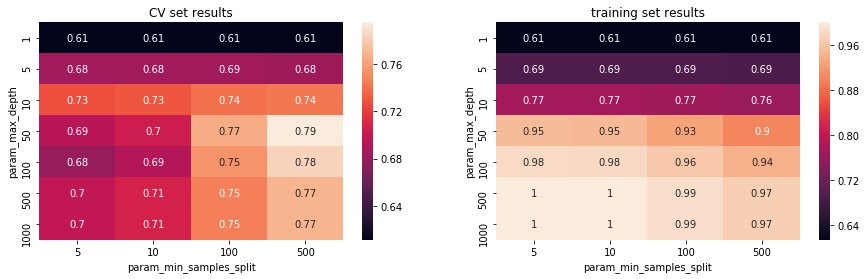

In [27]:
# Get the best hyperparameter using GridSearchCV 
get_best_hyperparameters(tf_idf_vect, X_train_tfidf, X_test_tfidf, y_train, y_test)

In [44]:
# Fitting the model with the best hyperparameter
model_tfidf = DecisionTreeClassifier(max_depth= 50, min_samples_split= 500, random_state= 507)
model_tfidf.fit(X_train_tfidf,y_train)
y_pred = model_tfidf.predict(X_test_tfidf)

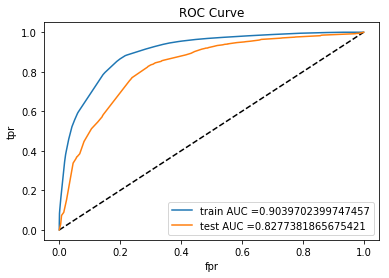

train AUC: 0.9039702399747457
test AUC: 0.8277381865675421


In [46]:
# AUC- ROC plot
auc_train_tfidf, auc_test_tfidf = plot_auc(model_tfidf, X_train_tfidf, X_test_tfidf)

In [47]:
# Confusion Matrix
print_confusion_matrix(model_tfidf, X_train_tfidf, X_test_tfidf)

*****Train confusion matrix*****
[[ 5551  4073]
 [ 2113 49704]]

*****Test confusion matrix*****
[[ 2111  2446]
 [ 1387 20388]]


<Figure size 432x288 with 0 Axes>

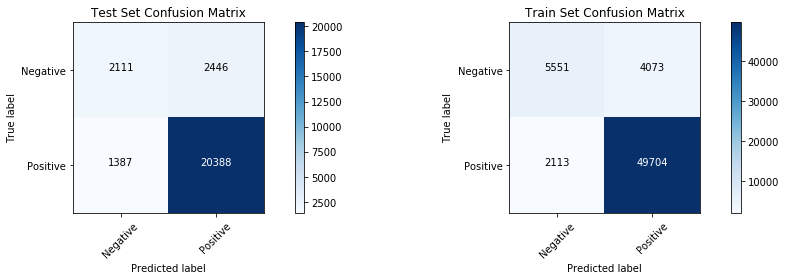

In [48]:
# Heatmap Confusion Matrix
plt.figure(1)
plt.figure(figsize=(15, 4))


plt.subplot(121)  # Test confusion matrix
cnf_matrix = confusion_matrix(y_test, model_tfidf.predict(X_test_tfidf))
np.set_printoptions(precision=2)
class_names = ['Negative', 'Positive']
# Plot non-normalized confusion matrix
#plt.figure()
plot_confusion_matrix_heatmap(cnf_matrix, classes=class_names, title='Test Set Confusion Matrix');

plt.subplot(122) # Train Confusion matrix
cnf_matrix = confusion_matrix(y_train, model_tfidf.predict(X_train_tfidf))
np.set_printoptions(precision=2)
class_names = ['Negative', 'Positive']
# Plot non-normalized confusion matrix
#plt.figure()
plot_confusion_matrix_heatmap(cnf_matrix, classes=class_names, title='Train Set Confusion Matrix');

**Observation**
1. For the TFIDF vectorizer, we calculated max_depth= 50 and min_samples_split= 500 using GridSearchCV for the DecisionTreeClassifier. 
2. We got train AUC: 0.9039702399747457 and test AUC: 0.8277381865675421
3. Using the confusion matrix, we can say that our model correctly predicted 20388 positive reviews and 2111 negative reviews.
4. The model incorrectly classified 1387 negative reviews and 2446 positive reviews.

### [5.2.1] Top 20 important features from<font color='red'> SET 2</font>

In [49]:
most_informative_feature_for_binary_classification(tf_idf_vect, model_tfidf)

+--------------------------+---------------+
| Coefficient (Importance) |  Feature Name |
+--------------------------+---------------+
|   0.10137005419134902    |      not      |
|   0.05204075324183794    |     great     |
|   0.039259743215712996   |     worst     |
|   0.03642855871993688    |  disappointed |
|   0.026023013545145128   |     money     |
|   0.024029274612239228   |     awful     |
|   0.023783643769020656   |      bad      |
|   0.023678598141716325   |    not buy    |
|   0.022035580042702743   |    horrible   |
|   0.021354501474108726   |    terrible   |
|   0.02082295803182179    |     return    |
|   0.018211719877531927   |     threw     |
|    0.0172706283668819    | not recommend |
|   0.014765720583619028   |   not worth   |
|   0.01460628947339885    |  waste money  |
|   0.014543360442087724   | disappointing |
|   0.013300877953397306   |      good     |
|   0.01253783958248458    |     refund    |
|   0.011737565443496233   |    product    |
|   0.0116

### [5.2.2] Graphviz visualization of Decision Tree on TFIDF,<font color='red'> SET 2</font>

In [50]:
model_tfidf_viz = DecisionTreeClassifier(max_depth= 3, min_samples_split= 500, random_state= 507)
model_tfidf_viz.fit(X_train_tfidf,y_train)
y_pred = model_tfidf_viz.predict(X_test_tfidf)

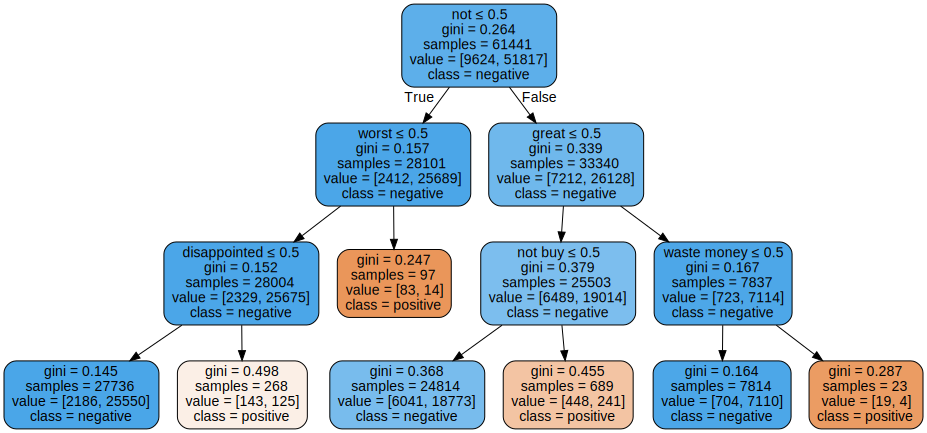

In [51]:
dt = plot_decision_tree(tf_idf_vect, model_tfidf_viz)
dt

## [4.4] Word2Vec

In [28]:
# Train your own Word2Vec model using your own text corpus 
i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())

In [29]:
print(list_of_sentance_train[0])

['bought', 'apartment', 'infested', 'fruit', 'flies', 'hours', 'trap', 'attracted', 'many', 'flies', 'within', 'days', 'practically', 'gone', 'may', 'not', 'long', 'term', 'solution', 'flies', 'driving', 'crazy', 'consider', 'buying', 'one', 'caution', 'surface', 'sticky', 'try', 'avoid', 'touching']


In [30]:
is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('terrific', 0.8240571022033691), ('fantastic', 0.8099831938743591), ('good', 0.8047497868537903), ('awesome', 0.7958186268806458), ('excellent', 0.7780699729919434), ('perfect', 0.7733269929885864), ('nice', 0.7343263626098633), ('wonderful', 0.726402759552002), ('amazing', 0.725594162940979), ('decent', 0.6865309476852417)]
[('greatest', 0.739180326461792), ('best', 0.720755934715271), ('coolest', 0.6763705611228943), ('tastiest', 0.6613165736198425), ('closest', 0.6220431327819824), ('nastiest', 0.6111527681350708), ('disgusting', 0.5959291458129883), ('ive', 0.5813934803009033), ('horrible', 0.5744800567626953), ('experienced', 0.5710225701332092)]


In [31]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  14799
sample words  ['bought', 'apartment', 'infested', 'fruit', 'flies', 'hours', 'trap', 'attracted', 'many', 'within', 'days', 'practically', 'gone', 'may', 'not', 'long', 'term', 'solution', 'driving', 'crazy', 'consider', 'buying', 'one', 'caution', 'surface', 'sticky', 'try', 'avoid', 'touching', 'really', 'good', 'idea', 'final', 'product', 'outstanding', 'use', 'car', 'window', 'everybody', 'asks', 'made', 'two', 'thumbs', 'received', 'shipment', 'could', 'hardly', 'wait', 'love', 'call']


**Converting train text data**

In [32]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
sent_vectors_train = np.array(sent_vectors_train)
print(sent_vectors_train.shape)
print(sent_vectors_train[0])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61441/61441 [01:38<00:00, 622.70it/s]


(61441, 50)
[ 0.22393003  0.09592169 -0.09882558 -0.17983183 -0.45694709 -0.16395379
  0.65210179 -0.43488005 -0.27133868  0.0204279   0.14940656  0.2592161
  0.10165668 -0.54464285 -0.32532377 -0.14426634 -0.00341055  0.22104419
  0.01885366  0.39250911  0.5225881   0.03777609 -0.24696966  0.01686862
  0.55910543  0.09677245 -0.62951185  0.21740808 -0.15631525 -0.32482856
 -0.43674826  0.46633292  0.08125676  0.29357839 -0.62140781 -0.04925572
 -0.02785743 -0.25851095 -0.57568086  0.23560735  0.07438516 -0.01472463
  0.09623523 -0.27007428  0.11128199 -0.46833002  0.02425915  0.06435714
 -0.66135578 -0.50526412]


**Converting test text data**

In [33]:
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

In [34]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)

print(sent_vectors_test.shape)
print(sent_vectors_test[0])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26332/26332 [00:46<00:00, 564.57it/s]


(26332, 50)
[-0.22952905 -0.29723563 -0.58708276 -0.39022837  0.37656512 -0.57715172
  0.14357275  0.17631177 -0.69216138  0.53853046 -0.20027078  0.56683548
 -0.45697219  0.35700065  0.23076544 -0.36637189  0.02887696  0.60715141
 -0.68229169  0.19939025 -0.06819704  0.0807292   0.20094279  0.56766275
  0.97304636  0.058633   -0.53569158 -0.17743056  0.45552647  0.35113259
 -0.08933651 -0.841273   -0.12200916  0.07369839  0.40343299  0.28087295
  0.70714661  0.99737026 -0.58868356  0.79578704 -0.11380306 -0.35850098
 -0.2681398  -0.41421369  0.06118299  0.80261823  0.19169296 -1.55092704
 -0.07266638 -0.85905036]


## [5.3] Applying Decision Trees on AVG W2V,<font color='red'> SET 3</font>

+---------------+--------------+-----------------------------------------------+
| Mean CV Score | Std CV Score |                     Param                     |
+---------------+--------------+-----------------------------------------------+
|     0.653     |    0.0089    |    {'max_depth': 1, 'min_samples_split': 5}   |
|     0.653     |    0.0089    |   {'max_depth': 1, 'min_samples_split': 10}   |
|     0.653     |    0.0089    |   {'max_depth': 1, 'min_samples_split': 100}  |
|     0.653     |    0.0089    |   {'max_depth': 1, 'min_samples_split': 500}  |
|     0.801     |   0.00638    |    {'max_depth': 5, 'min_samples_split': 5}   |
|     0.801     |   0.00638    |   {'max_depth': 5, 'min_samples_split': 10}   |
|     0.801     |   0.00609    |   {'max_depth': 5, 'min_samples_split': 100}  |
|     0.801     |   0.00609    |   {'max_depth': 5, 'min_samples_split': 500}  |
|     0.784     |   0.00907    |   {'max_depth': 10, 'min_samples_split': 5}   |
|     0.787     |   0.00664 

Text(0.5,1,'training set results')

<Figure size 432x288 with 0 Axes>

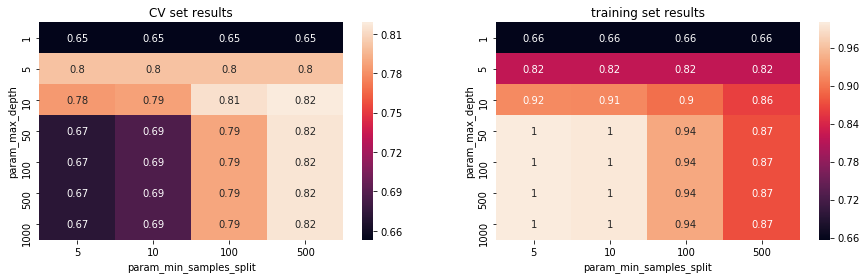

In [35]:
params_dict = {
                "max_depth": [1, 5, 10, 50, 100, 500, 1000], 
                "min_samples_split": [5, 10, 100, 500]
               }
    
clf = DecisionTreeClassifier(random_state= 507)
   
# Using GridSearchCVSearchCV with 5 fold cv
gs_obj = GridSearchCV(clf, param_grid = params_dict, scoring = 'roc_auc', cv=3)

gs_obj.fit(sent_vectors_train, y_train)
  
# Code https://stackoverflow.com/questions/42793254/what-replaces-gridsearchcv-grid-scores-in-scikit#answer-42800056
means = gs_obj.cv_results_['mean_test_score']
stds = gs_obj.cv_results_['std_test_score']


t1 = PrettyTable()
t1.field_names = ['Mean CV Score', 'Std CV Score', 'Param']

for mean, std, params in zip(means, stds, gs_obj.cv_results_['params']):
    t1.add_row([round(mean, 3), round(std * 2,5), params])

print(t1) 
  
print("\nThe best estimator:{}".format(gs_obj.best_estimator_))
print("\nThe best score is:{}".format(gs_obj.best_score_))
print("The best value of hyperparameters are:{}".format(gs_obj.best_params_))

# Returns the mean accuracy on the given test data and labels.
print("Mean Score: {}".format(gs_obj.score(sent_vectors_test, y_test)))
#print("penalty: {}".format(gs_obj.best_params_['penalty']))
    
#plotting heatmap
# https://stackoverflow.com/questions/48791709/how-to-plot-a-heat-map-on-pivot-table-after-grid-search
plt.figure(1)
plt.figure(figsize=(15, 4))
    
plt.subplot(121)
pvt = pd.pivot_table(pd.DataFrame(gs_obj.cv_results_),
          values='mean_test_score', index='param_max_depth', columns='param_min_samples_split')
    
ax = sns.heatmap(pvt,annot = True)
ax.set_title("CV set results")
    
plt.subplot(122) 
pvt2 = pd.pivot_table(pd.DataFrame(gs_obj.cv_results_),
          values='mean_train_score', index='param_max_depth', columns='param_min_samples_split')
    
ax2 = sns.heatmap(pvt2,annot = True, )
ax2.set_title('training set results')
    

In [65]:
# Fitting the model with the best hyperparameter
model_avgw2v = DecisionTreeClassifier(max_depth= 10, min_samples_split= 500, random_state= 507)
model_avgw2v.fit(sent_vectors_train,y_train)
y_pred = model_avgw2v.predict(sent_vectors_test)

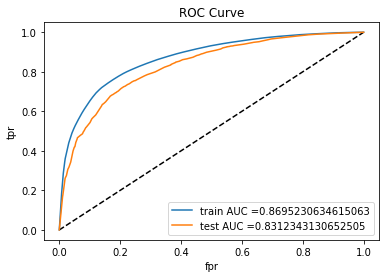

train AUC: 0.8695230634615063
test AUC: 0.8312343130652505


In [66]:
# AUC - ROC plot
auc_train_avgw2v, auc_test_avgw2v = plot_auc(model_avgw2v, sent_vectors_train, sent_vectors_test)

In [67]:
# Confusion matrix
print_confusion_matrix(model_avgw2v, sent_vectors_train, sent_vectors_test)

*****Train confusion matrix*****
[[ 3159  6465]
 [ 1469 50348]]

*****Test confusion matrix*****
[[ 1410  3147]
 [  776 20999]]


<Figure size 432x288 with 0 Axes>

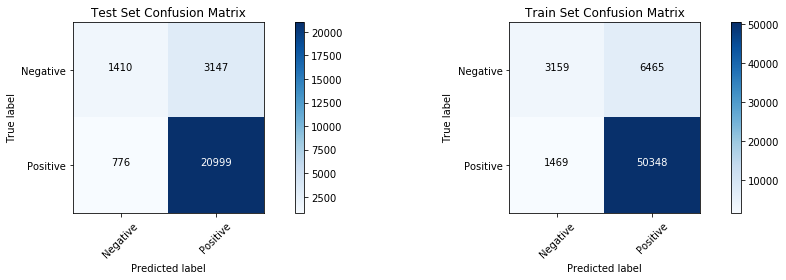

In [68]:
# Heatmap confusion matrix
plt.figure(1)
plt.figure(figsize=(15, 4))


plt.subplot(121)  # Test confusion matrix
cnf_matrix = confusion_matrix(y_test, model_avgw2v.predict(sent_vectors_test))
np.set_printoptions(precision=2)
class_names = ['Negative', 'Positive']
# Plot non-normalized confusion matrix
#plt.figure()
plot_confusion_matrix_heatmap(cnf_matrix, classes=class_names, title='Test Set Confusion Matrix');

plt.subplot(122) # Train Confusion matrix
cnf_matrix = confusion_matrix(y_train, model_avgw2v.predict(sent_vectors_train))
np.set_printoptions(precision=2)
class_names = ['Negative', 'Positive']
# Plot non-normalized confusion matrix
#plt.figure()
plot_confusion_matrix_heatmap(cnf_matrix, classes=class_names, title='Train Set Confusion Matrix');

**Observation**
1. For the Avg W2V vectorizer, we calculated max_depth= 10 and min_samples_split= 500 using GridSearchCV for the DecisionTreeClassifier. 
2. We got train AUC: 0.8695230634615063 and test AUC: 0.8312343130652505
3. Using the confusion matrix, we can say that our model correctly predicted 20999 positive reviews and 1410 negative reviews.
4. The model incorrectly classified 776 negative reviews and 3147 positive reviews.


#### [4.4.1.2] TFIDF weighted W2v

In [36]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
X_train_tf_idf_w2v = model.fit_transform(X_train)
X_test_tf_idf_w2v = model.transform(X_test)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [37]:
# TF-IDF weighted Word2Vec for sentences in X_train
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61441/61441 [25:11<00:00, 40.64it/s]


In [38]:
# TF-IDF weighted Word2Vec for sentences in X_test
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    
    row += 1

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26332/26332 [12:08<00:00, 36.16it/s]


### [5.1.4]  Applying Linear SVM on TFIDF W2V,<font color='red'> SET 4</font>

+---------------+--------------+-----------------------------------------------+
| Mean CV Score | Std CV Score |                     Param                     |
+---------------+--------------+-----------------------------------------------+
|     0.632     |   0.01257    |    {'max_depth': 1, 'min_samples_split': 5}   |
|     0.632     |   0.01257    |   {'max_depth': 1, 'min_samples_split': 10}   |
|     0.632     |   0.01257    |   {'max_depth': 1, 'min_samples_split': 100}  |
|     0.632     |   0.01257    |   {'max_depth': 1, 'min_samples_split': 500}  |
|     0.764     |   0.01115    |    {'max_depth': 5, 'min_samples_split': 5}   |
|     0.764     |   0.01115    |   {'max_depth': 5, 'min_samples_split': 10}   |
|     0.764     |   0.01115    |   {'max_depth': 5, 'min_samples_split': 100}  |
|     0.764     |   0.00995    |   {'max_depth': 5, 'min_samples_split': 500}  |
|     0.754     |   0.01671    |   {'max_depth': 10, 'min_samples_split': 5}   |
|     0.755     |   0.01653 

<Figure size 432x288 with 0 Axes>

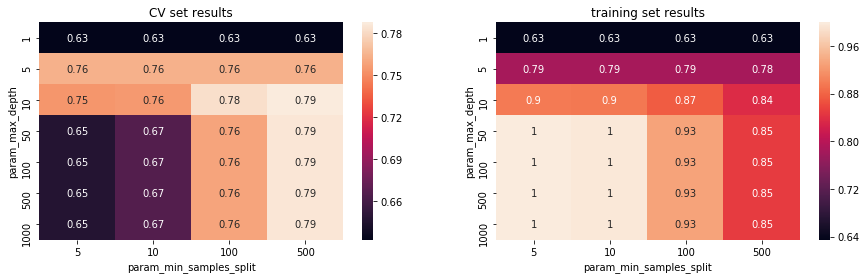

In [39]:
get_best_hyperparameters(model, tfidf_sent_vectors_train, tfidf_sent_vectors_test, y_train, y_test)

In [69]:
# Fitting the TFIDF - weighted W2V vectorizer on LogisticRegression Model 
model_tfidfw2v = DecisionTreeClassifier(max_depth= 10, min_samples_split= 500, random_state= 507)
model_tfidfw2v.fit(tfidf_sent_vectors_train,y_train)
y_pred = model_tfidfw2v.predict(tfidf_sent_vectors_test)

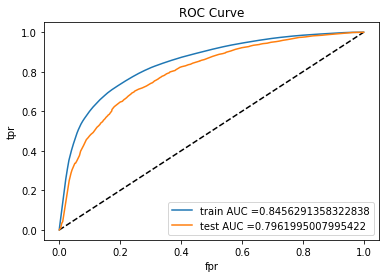

train AUC: 0.8456291358322838
test AUC: 0.7961995007995422


In [70]:
# AUC- ROC plot
auc_train_tfidfw2v, auc_test_tfidfw2v = plot_auc(model_tfidfw2v, tfidf_sent_vectors_train, tfidf_sent_vectors_test)

In [71]:
# Confusion Matrix
print_confusion_matrix(model_tfidfw2v, tfidf_sent_vectors_train, tfidf_sent_vectors_test)

*****Train confusion matrix*****
[[ 2752  6872]
 [ 1461 50356]]

*****Test confusion matrix*****
[[ 1207  3350]
 [  889 20886]]


<Figure size 432x288 with 0 Axes>

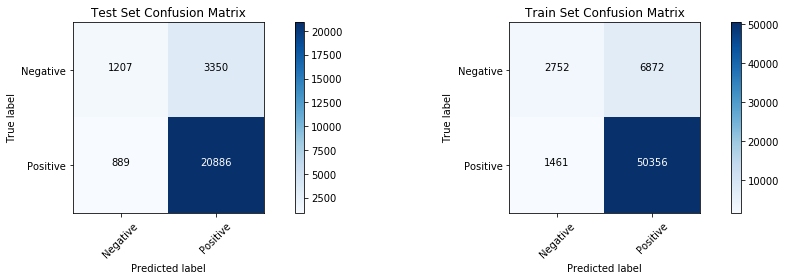

In [72]:
# Heatmap Confusion Matrix
plt.figure(1)
plt.figure(figsize=(15, 4))


plt.subplot(121)  # Test confusion matrix
cnf_matrix = confusion_matrix(y_test, model_tfidfw2v.predict(tfidf_sent_vectors_test))
np.set_printoptions(precision=2)
class_names = ['Negative', 'Positive']
# Plot non-normalized confusion matrix
#plt.figure()
plot_confusion_matrix_heatmap(cnf_matrix, classes=class_names, title='Test Set Confusion Matrix');

plt.subplot(122) # Train Confusion matrix
cnf_matrix = confusion_matrix(y_train, model_tfidfw2v.predict(tfidf_sent_vectors_train))
np.set_printoptions(precision=2)
class_names = ['Negative', 'Positive']
# Plot non-normalized confusion matrix
#plt.figure()
plot_confusion_matrix_heatmap(cnf_matrix, classes=class_names, title='Train Set Confusion Matrix');

**Observation**
1. For the TFIDF- weighted W2V vectorizer, we calculated max_depth= 10 and min_samples_split= 500 using GridSearchCV for the DecisionTreeClassifier. 
2. We got train AUC: 0.8456291358322838 and test AUC: 0.7961995007995422
3. Using the confusion matrix, we can say that our model correctly predicted 20886 positive reviews and 1207 negative reviews.
4. The model incorrectly classified 889 negative reviews and 3350 positive reviews.

In [ ]:
#del final, X_train_bow, X_test_bow,X_train_bow_fe, X_test_bow_fe, X,y

#del X_train_tfidf, X_test, y_train, y_test#, X_train_bow, X_test_bow,X_train_bow_fe, X_test_bow_fe
#del w2v_words, tfidf_feat, tfidf_sent_vectors_test, tfidf_sent_vectors_train, sent_vectors_test, sent_vectors_train, sent_vec

# [6] Conclusions

In [94]:
C = PrettyTable()

C.field_names = ['Sr. No', 'Vectorizer','max_depth',' min_samples_split', 'Train AUC', 'Test AUC']
C.add_row([1, 'BoW', 50, 500, auc_train_bow, auc_test_bow])
C.add_row([2, 'TF_IDF', 50, 500, auc_train_tfidf, auc_test_tfidf])
C.add_row([3, 'Avg-W2V',  10, 500,auc_train_avgw2v, auc_test_avgw2v])
C.add_row([4, 'TFIDF-W2V', 10, 500,auc_train_tfidfw2v, auc_test_tfidfw2v])
           

print(C)
del C

+--------+------------+-----------+--------------------+--------------------+--------------------+
| Sr. No | Vectorizer | max_depth |  min_samples_split |     Train AUC      |      Test AUC      |
+--------+------------+-----------+--------------------+--------------------+--------------------+
|   1    |    BoW     |     50    |        500         | 0.9033231564850217 | 0.8452604148951903 |
|   2    |   TF_IDF   |     50    |        500         | 0.9039702399747457 | 0.8277381865675421 |
|   3    |  Avg-W2V   |     10    |        500         | 0.8695230634615063 | 0.8312343130652505 |
|   4    | TFIDF-W2V  |     10    |        500         | 0.8456291358322838 | 0.7961995007995422 |
+--------+------------+-----------+--------------------+--------------------+--------------------+


## Summary

1. We implemented Decision Tree Classifier on the Amazon fine food dataset. 
2. Made use of GridSearchCV to find the best value of max_depth and min_samples_split.
3. Performed Feature Engineering on the BoW model and found out the model slightly performed better.
4. Different vectors take on different hyperparameter values. We saw values being taken from  "max_depth" = [1, 5, 10, 50, 100, 500, 1000] and "min_samples_split": [5, 10, 100, 500]
5. We visualize the decision tree using the graphviz tool and plot the tree for BoW and TF-IDF.
6. We also printed out feature importance for BoW and TFIDF vectorizer 